# Proyecto de detección de anomalías  v7

- Red Neuronal Convolucional que implementa procesamiento de imagenes usando tomografías de pecho para detectar síntomas de neumonía y tumores pulmonares. Esta versión del proyecto utiliza Transfer Learning, es decir, usa un modelo previamente entrenado (ResNet 34).

> Este repositorio no incluye el data set, pues es muy pesado. Aqui puedes encontrar el [dataset completo de radiografías](https://drive.google.com/drive/u/2/folders/1FpSvkSt2oqENdJPizx_UeRBoI96cCpZf), descargalo y agregalo al folder.

Importaciones necesarias para el modelo:

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision import models
import matplotlib.pyplot as plt

In [2]:
switch = int(input('Are you in the Mac or in the PC? Use 1 to indicate you are using Mac', ))

if switch == 1:
    
    trainPath = '/Users/fervargas/Developer/py/cnn/fullDS/train'
    testPath = '/Users/fervargas/Developer/py/cnn/fullDS/test'
    ValidationPath = '/Users/fervargas/Developer/py/cnn/fullDS/val' 
else:
    trainPath = "C:/Users/ferva/Developer/pulmonAID/chest_xray/train"
    testPath = "C:/Users/ferva/Developer/pulmonAID/chest_xray/test"
    ValidationPath = "C:/Users/ferva/Developer/pulmonAID/chest_xray/val"
transform = T.Compose([
        T.Resize([224,224]),
        T.ToTensor(),
        T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

In [3]:
# Crear data sets para los entrenamientos, la validacion y las pruebas
trainDS = datasets.ImageFolder(trainPath, transform=transform)
valDS = datasets.ImageFolder(ValidationPath, transform=transform)
testDS = datasets.ImageFolder(testPath, transform=transform)

In [4]:
batchSize = 64

trainLoader = DataLoader(dataset=trainDS, batch_size=batchSize, shuffle=True)
valLoader = DataLoader(dataset=valDS, batch_size=batchSize, shuffle=True)
testLoader = DataLoader(dataset=testDS, batch_size=batchSize, shuffle=True)

In [5]:
for i, (x, y) in enumerate(valLoader):
    print(i, x.shape, y.shape)

0 torch.Size([39, 3, 224, 224]) torch.Size([39])


In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cpu


La imagen representa: NORMAL


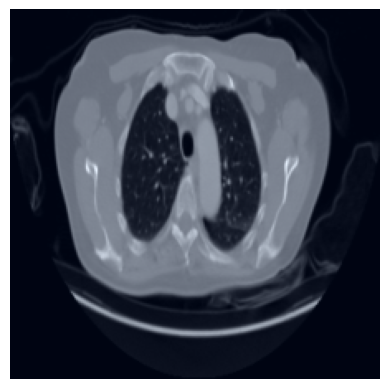

In [7]:
categorias = ['NORMAL', 'PNEUMONIA', 'CANCER']

def plot_image(image):
    plt.imshow(image.permute(1,2,0))
    plt.axis('off')
    plt.show()

sample_id = np.random.randint(int(len(testLoader)))
print(f'La imagen representa: {categorias[testLoader.dataset[sample_id][1]]}')
image = testLoader.dataset[sample_id][0]
image = (image - image.min()) / (image.max() - image.min())
plot_image(image)

In [8]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)
        return float(num_correct)/num_total   


In [9]:
model_resnet34 = models.resnet34()

In [ ]:
model_aux = nn.Sequential(*list(model_resnet34.children()))

In [ ]:
model_aux = nn.Sequential(*list(model_resnet34.children())[:-1])

In [ ]:
for i, parameter in enumerate(model_aux.parameters()):
    parameter.requires_grad = True
    print(i, parameter.requires_grad)

In [14]:
def train(model, optimiser, epochs=100):
#     def train(model, optimiser, scheduler = None, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for i, (xi, yi) in enumerate(trainLoader):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)

            cost = F.cross_entropy(input= scores, target=yi)
        
            optimiser.zero_grad()           
            cost.backward()
            optimiser.step()           
            
        acc = accuracy(model, valLoader)
#         if epoch%5 == 0:     
        print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {acc},')
#         scheduler.step()

In [15]:
hidden1 = 256 
hidden = 256
lr = 1e-4
epochs = 5
# model1 = nn.  Sequential(nn.Flatten(),
#                        nn.Linear(in_features=32*32*3, out_features=hidden1), nn.ReLU(),
#                        nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
#                        nn.Linear(in_features=hidden, out_features=10))

model1 = nn.Sequential(model_aux,
                       nn.Flatten(), 
                       nn.Linear(in_features=512, out_features= 3, bias= True))
optimiser = torch.optim.Adam(model1.parameters(), lr=lr, betas=(0.9, 0.999))

# train(model1, optimiser, epochs)

In [16]:
train(model1, optimiser, epochs)
accuracy(model1, testLoader)

Epoch: 0, costo: 0.05848480015993118, accuracy: 0.4358974358974359,
Epoch: 1, costo: 0.026359068229794502, accuracy: 0.7435897435897436,
Epoch: 2, costo: 0.019800875335931778, accuracy: 0.8974358974358975,
Epoch: 3, costo: 0.014413408003747463, accuracy: 0.9487179487179487,
Epoch: 4, costo: 0.03665297105908394, accuracy: 0.8205128205128205,


0.7244623655913979

In [18]:
def getIndex(lista):
  result = lista.index(max(lista))
  return result

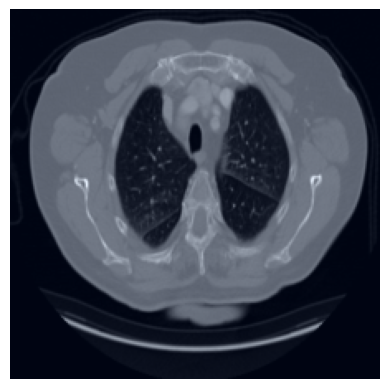

Esta imagen representa: CANCER


In [19]:
# Prediccion post-entrenamiento de COVID, PNEUMONIA y pulmones sanos (NORMAL)

model = model1.to(device=device)
sample_id = np.random.randint(int(len(testLoader)))
image = testLoader.dataset[sample_id][0]
image = (image - image.min()) / (image.max() - image.min())
plot_image(image)
nScores = model(image.to(device=device).unsqueeze(0))
scoreArray = nScores.tolist()
print(f'{scoreArray}\n Esta imagen representa: {categorias[getIndex(scoreArray[0])]}')
#print(f'La imagen representa: {categorias[testLoader.dataset[sample_id][1]]}')